In [49]:
#%matplotlib ipympl
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#from torchview import draw_graph
#import graphviz

100%|██████████| 50000/50000 [00:01<00:00, 30841.68it/s]


Label distribution: (array([0, 1, 2]), array([16736, 16702, 16562]))


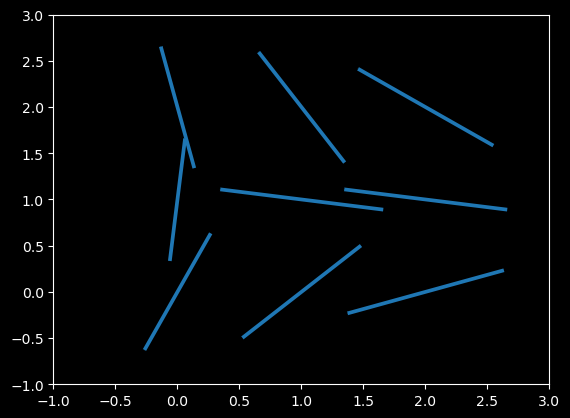

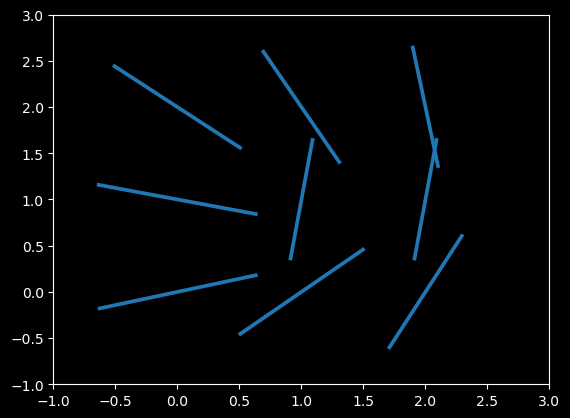

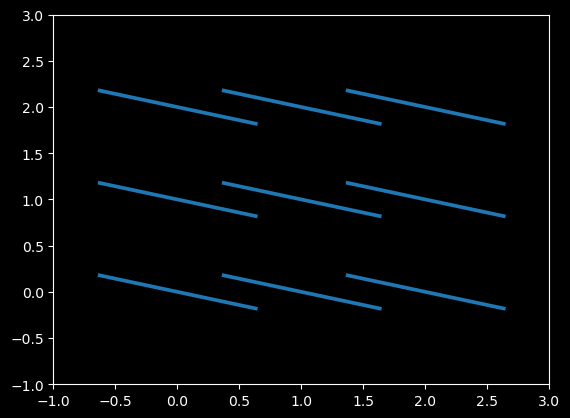

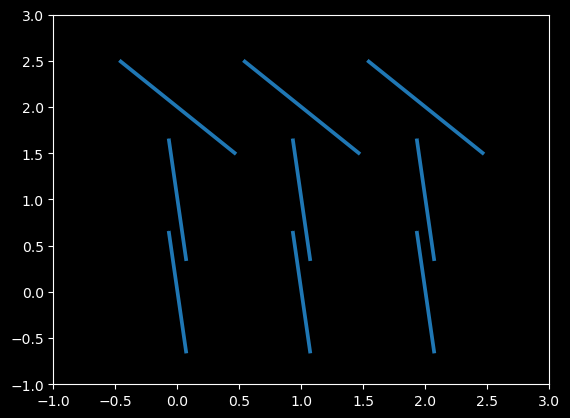

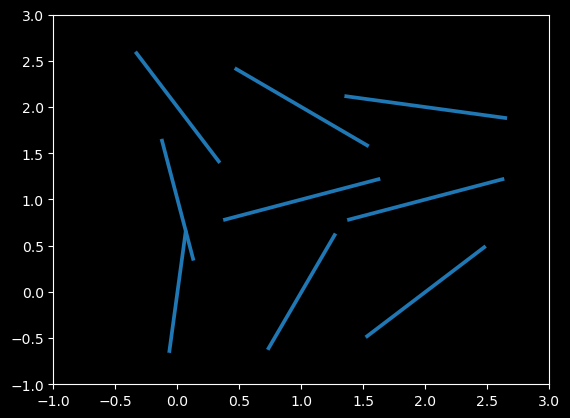

In [50]:
def generate_defect_field(size=100, defect_type='+1/2', defect_location=(1, 1)):
    x, y = np.meshgrid(np.arange(size), np.arange(size))
    field = np.zeros((size, size, 2))
    rotation = np.random.uniform(0,np.pi*2)
    # Generate a +1/2 defect
    if defect_type == '+1/2':
        charge = 0.5
        r = np.sqrt((x - defect_location[0]) ** 2 + (y - defect_location[1]) ** 2)
        theta = charge*np.arctan2(y - defect_location[1], x - defect_location[0]) + rotation
        field[:, :, 0] = np.sin(theta)
        field[:, :, 1] = -np.cos(theta)

    # Generate a -1/2 defect
    elif defect_type == '-1/2':
        charge = -0.5
        r = np.sqrt((x - defect_location[0]) ** 2 + (y - defect_location[1]) ** 2)
        theta = charge*np.arctan2(y - defect_location[1], x - defect_location[0]) + rotation
        field[:, :, 0] = -np.sin(theta)
        field[:, :, 1] = np.cos(theta)
    elif defect_type == 'none':
        # 25% of the "none" director fields should have a row or column of vectors flipped because of the way that the data is generated
        # note: should this have just random singular vector flips for the data?
        if np.random.rand() > 0.75: 
            theta = np.random.uniform(0,np.pi*2)
            field[:,:,0] = np.sin(theta)
            field[:,:,1] = -np.cos(theta)
            # a flipping a row of vectors
            if np.random.rand() > 0.5:
                iflip = np.random.randint(3)
                field[iflip,:,0] = np.sin(theta*np.pi)
                field[iflip,:,1] = -np.cos(theta*np.pi)
            else:
                iflip = np.random.randint(3)
                field[:,iflip,0] = np.sin(theta*np.pi)
                field[:,iflip,0] = -np.cos(theta*np.pi)
        else:
            theta = np.random.uniform(0,np.pi*2)
            field[:, :, 0] = np.sin(theta)
            field[:, :, 1] = -np.cos(theta)
    norm = np.sqrt(field[:,:,0]**2 + field[:,:,1]**2)
    field[:,:,0] = field[:,:,0]/norm
    field[:,:,1] = field[:,:,1]/norm
    return field

def plot_defect_field(field):
    size = field.shape[0]
    x, y = np.meshgrid(np.arange(size), np.arange(size))
    plt.quiver(x,y,field[:, :, 0], field[:, :, 1],
                   pivot='mid',
                   headlength=0.2,
                   headwidth=0.2,
                   headaxislength=0.1,
                   color="tab:blue",
                   scale_units='xy',
                   scale=0.75
    )
    plt.xlim(-1,3)
    plt.ylim(-1,3)
    plt.show()

def generate_labeled_dataset(num_samples=100, size=100):
    X = []
    y = []

    for _ in tqdm.tqdm(range(num_samples)):
        # Randomly choose a defect type and location
        defect_type = np.random.choice(['+1/2', '-1/2','none'])
        defect_location = (1,1)#(np.random.randint(size), np.random.randint(size))
        # Generate the defect field
        defect_field = generate_defect_field(size=size, defect_type=defect_type, defect_location=defect_location)

        # Append to the dataset
        X.append(defect_field.flatten())
        if defect_type == "+1/2":
            y.append(1)
        elif defect_type == "-1/2":
            y.append(2)
        else:
            y.append(0)
        #y.append(1 if defect_type == '+1/2' else 0)

    return np.array(X), np.array(y)
                    
# Example usage:
num_samples = 50000
size = 3

X, y = generate_labeled_dataset(num_samples=num_samples, size=size)

# Print labels to check the distribution of +1/2 and -1/2 defects
print("Label distribution:", np.unique(y, return_counts=True))

# Visualize a few examples
test_pos_field = generate_defect_field(size,"+1/2",(1,1))

# test_neg_field = generate_defect_field(size,"-1/2",(1,1),1)
# w = get_winding_number(test_neg_field,(1,1))
# print(w,"-1/2")
# w = calculate_winding_number(test_field)
# print(w)
        
for i in range(5):
    plot_defect_field(X[i].reshape((size, size, 2)))

(3, 3, 2)


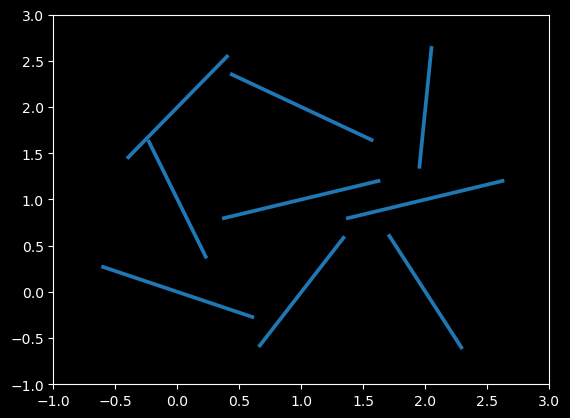

(1, 1)
0 (1, 2) 13.53102386891094 0.0 13.53102386891094
1 (0, 2) 13.53102386891094 -57.15481083685933 70.68583470577028
0.0
70.68583470577028
2 (0, 1) -127.84064554262969 -127.84064554262969 0.0
70.68583470577028
70.68583470577028
3 (0, 0) 161.47351975159992 161.47351975159992 0.0
70.68583470577028
70.68583470577028
4 (1, 0) -63.72563730800759 -63.72563730800759 0.0
70.68583470577028
70.68583470577028
5 (2, 0) -134.41147201377797 -134.41147201377797 0.0
70.68583470577028
70.68583470577028
6 (2, 1) 154.9026932804517 154.9026932804517 0.0
70.68583470577028
70.68583470577028
7 (2, 2) 84.21685857468121 84.21685857468121 0.0
70.68583470577028
70.68583470577028
70.68583470577028 +1/2


In [11]:
def get_winding_number(field,loc):
    """ returns a winding number in radians for the rotation of vectors around the defect core
    inputs:
            field: a 2d vector field [x,y,u,v] of director field
            loc: a tuple containing the defect location
    returns:
            w: winding number of defect located at 'loc' in radians
    """
    u = field[:,:,0]
    v = field[:,:,1]
    dx = [0,-1,-1,-1,0,1,1,1]
    dy = [1,1,0,-1,-1,-1,0,1]
    w = 0.0
    print(loc)
    v1 = np.zeros(2)
    v2 = np.zeros(2)
    v1[0] = u[loc[0] + dx[0],loc[1] + dy[0]]
    v1[1] = v[loc[0] + dx[0],loc[1] + dy[0]]
    print(0,
          (loc[0]+dx[0],loc[1]+dy[0]),
          np.rad2deg(np.arctan2(v1[1],v1[0])),
          np.rad2deg(np.arctan2(v2[1],v2[0])),
          np.rad2deg(np.arctan2(v1[1],v1[0]))-np.rad2deg(np.arctan2(v2[1],v2[0])))
    for iloc in range(1,len(dx)):
        v2[0] = u[loc[0] + dx[iloc],loc[1] + dy[iloc]]
        v2[1] = v[loc[0] + dx[iloc],loc[1] + dy[iloc]]
        print(iloc,
              (loc[0]+dx[iloc],loc[1]+dy[iloc]),
              np.rad2deg(np.arctan2(v1[1],v1[0])),
              np.rad2deg(np.arctan2(v2[1],v2[0])),
              np.rad2deg(np.arctan2(v1[1],v1[0]))-np.rad2deg(np.arctan2(v2[1],v2[0])))
        #w += np.arccos(np.clip(np.dot(v2, v1), -1.0, 1.0))
        print(w)
        w += np.rad2deg(np.arctan2(v1[1],v1[0]))-np.rad2deg(np.arctan2(v2[1],v2[0]))
        print(w)
        v1 = v2
    return w
print(test_pos_field.shape)
plot_defect_field(test_pos_field)
w = get_winding_number(test_pos_field,(1,1))
print(w,"+1/2")

In [51]:
if torch.cuda.is_available(): 
    print("CUDA AVAILABLE")
    dev = "cuda:0" 
else: 
    dev = "cpu"
device = torch.device(dev)
# Assuming you have X and y from the generate_labeled_dataset function

# Convert NumPy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a simple neural network model
class DefectClassifier(nn.Module):
    def __init__(self, input_size):
        super(DefectClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)  # Additional hidden layer
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64,64)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(64, 3)  # Output layer for 3 classes [-1/2, +1/2, no defect]
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.softmax(x)
        return x
"""
class DefectClassifier(nn.Module):
    def __init__(self, input_size):
        super(DefectClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)  # Additional hidden layer
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 3)  # Output layer for 3 classes [-1/2, +1/2, no defect]
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x
"""
"""       
class DefectClassifier(nn.Module):
    def __init__(self, input_size):
        super(DefectClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 3) #output size changed to 3 for 3 classes [-1/2,+1/2,no defect]
        #self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        #x = self.sigmoid(x)
        x = self.softmax(x)
        return x
"""

# Initialize the model, loss function, and optimizer
print(X_tensor.shape)
model = DefectClassifier(input_size=X_tensor.shape[1])
model.to(device)
#criterion = nn.BCELoss() # criterion for just predicting +1/2, -1/2
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set up early stopping
best_model_state_dict = None
best_validation_loss = float('inf')
patience = 10 # Adjust this based on your scenario
counter = 0

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    #loss = criterion(outputs, y_train.view(-1, 1))
    loss = criterion(outputs, y_train.long())

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate validation loss
    with torch.no_grad():
        model.eval()
        validation_outputs = model(X_validation)
        validation_loss = criterion(validation_outputs, y_validation.long())
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.16f}')
        print(f'Validation Loss: {validation_loss.item():.16f} best_validation_loss: {best_validation_loss:.16f}')
    #print(validation_loss.item(),best_validation_loss,np.abs(validation_loss-best_validation_loss))
    # Check for early stopping
    if validation_loss.item() <= best_validation_loss:
    #if np.isclose(np.abs(validation_loss-best_validation_loss),0.0,rtol=1e-15):
    #if np.isclose(validation_loss.item(), best_validation_loss, rtol=1e-15):
        best_validation_loss = validation_loss
        best_model_state_dict = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping after {epoch + 1} epochs.')
            break

# Load the best model
model.load_state_dict(best_model_state_dict)

# Evaluate the model on the test set
with torch.no_grad():
    model.eval()
    # y_pred = (model(X_test) > 0.5).float()
    # print(classification_report(y_test.numpy(), y_pred.numpy()))
    outputs_validation = model(X_validation)
    predictions_validation = torch.argmax(outputs_validation,dim=1)
    accuracy = (predictions_validation == y_validation).float().mean().item()
print(f"Validation Accuracy: {accuracy:.8f}")
print(summary(model,X_tensor.shape))
#moving model back to CPU for inference and processing
with torch.no_grad():
    if torch.cuda.is_available():
        device = torch.device("cpu")
        model.to(device)
    

torch.Size([50000, 18])
Epoch [10/100], Loss: 1.0756770372390747
Validation Loss: 1.0721138715744019 best_validation_loss: 1.0759148597717285
Epoch [20/100], Loss: 1.0160280466079712
Validation Loss: 1.0075148344039917 best_validation_loss: 1.0168535709381104
Epoch [30/100], Loss: 0.8876423239707947
Validation Loss: 0.8740708827972412 best_validation_loss: 0.8898619413375854
Epoch [40/100], Loss: 0.7276892662048340
Validation Loss: 0.7151725888252258 best_validation_loss: 0.7303013801574707
Epoch [50/100], Loss: 0.6073722839355469
Validation Loss: 0.6023722887039185 best_validation_loss: 0.6093963980674744
Epoch [60/100], Loss: 0.5689554214477539
Validation Loss: 0.5695721507072449 best_validation_loss: 0.5710633993148804
Epoch [70/100], Loss: 0.5596669912338257
Validation Loss: 0.5606809258460999 best_validation_loss: 0.5612888932228088
Epoch [80/100], Loss: 0.5558873414993286
Validation Loss: 0.5565360188484192 best_validation_loss: 0.5568261742591858
Epoch [90/100], Loss: 0.55409979

In [41]:
# Assuming you have a single test field as a NumPy array called 'single_test_field'
defect_type = np.random.choice(['+1/2', '-1/2','none'])
test_field = generate_defect_field(size=3, 
                                    defect_type=defect_type,
                                    defect_location=(1,1))
print(defect_type)
test_tensor = torch.tensor(test_field.flatten(), dtype=torch.float32).unsqueeze(0)

# Make a prediction
with torch.no_grad():
    model.eval()
    output = model(test_tensor)
    prediction = torch.argmax(output,dim=1)

defect_types = ["No Defect", "+1/2 Defect", "-1/2 Defect"]
label = defect_types[prediction.item()]
print(prediction.item())
print("Prediction:", label)

+1/2
1
Prediction: +1/2 Defect


In [42]:
# here we're going to generate another dataset and test the model against it
num_samples = 1000
size = 3

X2, y2 = generate_labeled_dataset(num_samples=num_samples, size=size)
X2_tensor = torch.tensor(X2, dtype=torch.float32)
y2_tensor = torch.tensor(y2, dtype=torch.float32)
with torch.no_grad():
    model.eval()
    # y_pred = (model(X_test) > 0.5).float()
    # print(classification_report(y_test.numpy(), y_pred.numpy()))
    outputs_validation = model(X2_tensor)
    predictions_validation = torch.argmax(outputs_validation,dim=1)
    accuracy = (predictions_validation == y2_tensor).float().mean().item()
print(f"Validation Accuracy: {accuracy:.8f}")

100%|██████████| 1000/1000 [00:00<00:00, 22866.96it/s]

Validation Accuracy: 1.00000000


(100, 100)


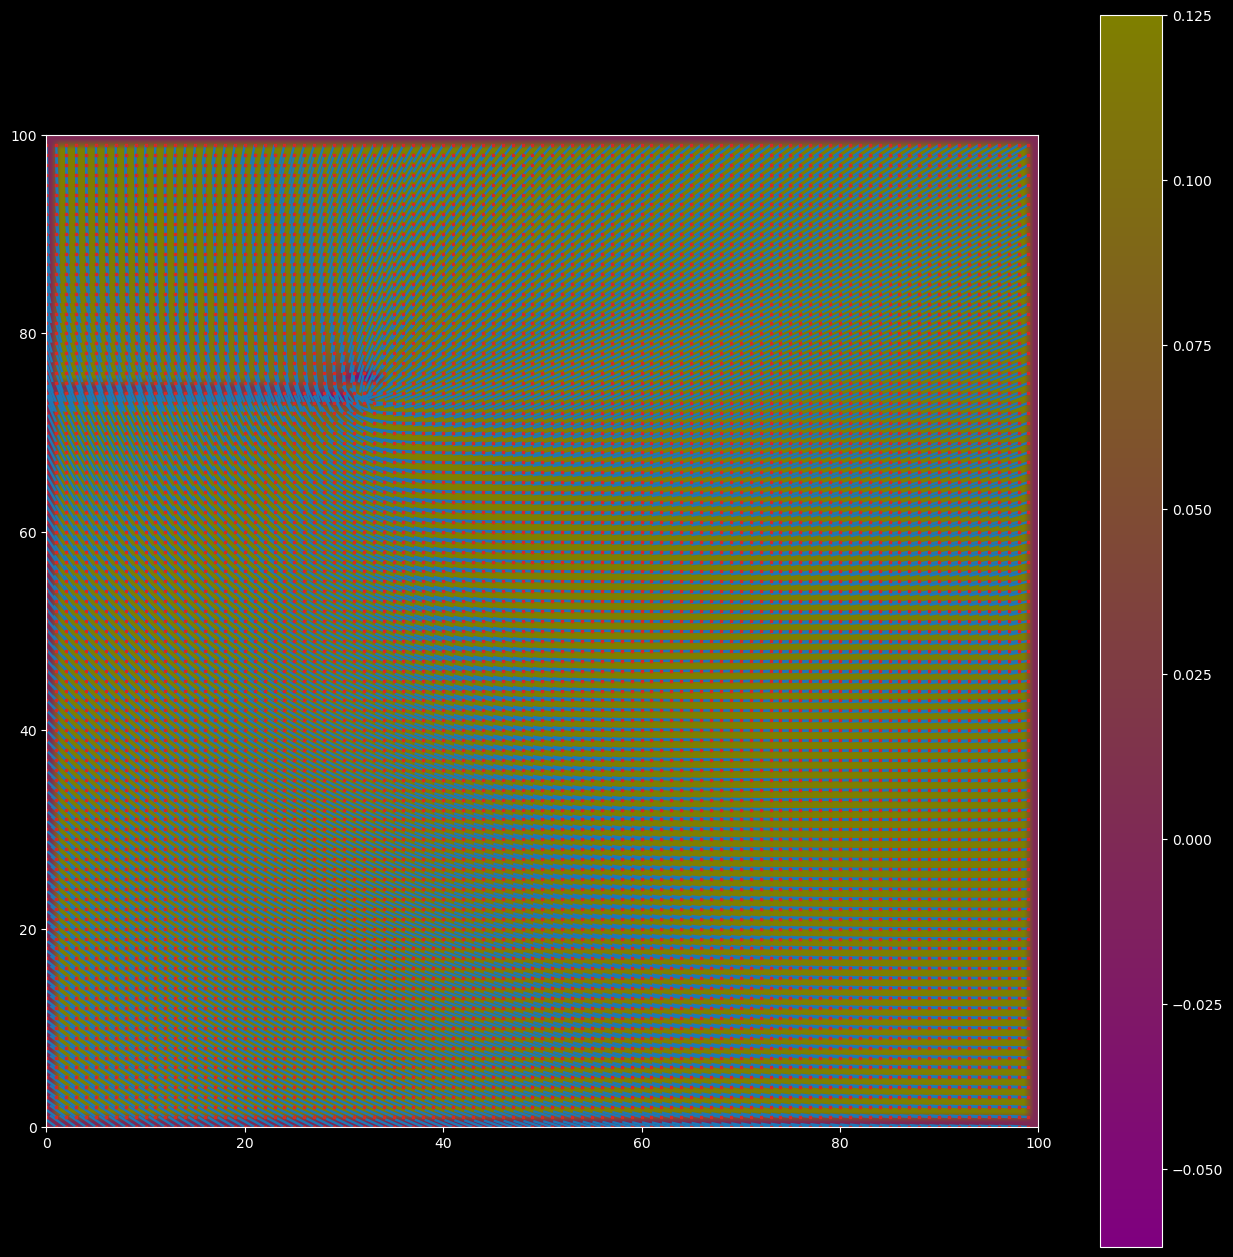

In [43]:
def calculate_order_parameter(field):
    # Assuming field is a 2D array of vectors (size x size x 2)
    S = np.zeros((field.shape[0],field.shape[1]))
    for i in np.arange(1,field.shape[0]-1):
        for j in np.arange(1,field.shape[1]-1):
            nx = field[i,j,0]
            ny = field[i,j,1]
            orig_theta = np.arctan2(ny,nx)
            theta = 3*(np.cos((np.arctan2(field[i+1,j,1],field[i+1,j,0])-orig_theta)+
                              (np.arctan2(field[i+1,j+1,1],field[i+1,j,0])-orig_theta)+
                              (np.arctan2(field[i+1,j-1,1],field[i+1,j,0])-orig_theta)+
                              (np.arctan2(field[i,j+1,1],field[i+1,j,0])-orig_theta)+
                              (np.arctan2(field[i,j-1,1],field[i+1,j,0])-orig_theta)+
                              (np.arctan2(field[i-1,j+1,1],field[i+1,j,0])-orig_theta)+
                              (np.arctan2(field[i-1,j,1],field[i+1,j,0])-orig_theta)+
                              (np.arctan2(field[i-1,j-1,1],field[i+1,j,0])-orig_theta))**2)-1

            S[i,j] = 0.5*theta/8

    return S

# Generate a defect field
defect_field = generate_defect_field(size=100, 
                                   defect_type=np.random.choice(["+1/2","-1/2"]), 
                                   defect_location=(np.random.randint(2,98),np.random.randint(2,98)))
order_parameter_original = calculate_order_parameter(defect_field)

# Plot the original and interpolated defect fields with the order parameter
fig,ax = plt.subplots(1,1,figsize=(16,16))
x, y = np.meshgrid(np.arange(100), np.arange(100))
quiver = ax.quiver(x,y,
                   defect_field[:,:,0], #x
                   defect_field[:,:,1], #y
                   pivot='tip',
                   headlength=0,
                   headwidth=0,
                   headaxislength=0,
                   color="tab:blue",
                   scale_units='xy',
                   scale=0.5
)
print(order_parameter_original.shape)
ax.scatter(x,y,color="tab:red",marker=",",s=1) #plots heads of vectors if pivot="tip"
pcm = ax.imshow(order_parameter_original,cmap="spring",interpolation="bilinear",alpha=0.5,origin="lower",extent=(0,100,0,100))
fig.colorbar(pcm, ax=ax)
ax.axis("scaled")
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
plt.show()

+1/2
(80, 37)
(98, 98, 3, 3)
(3, 3)


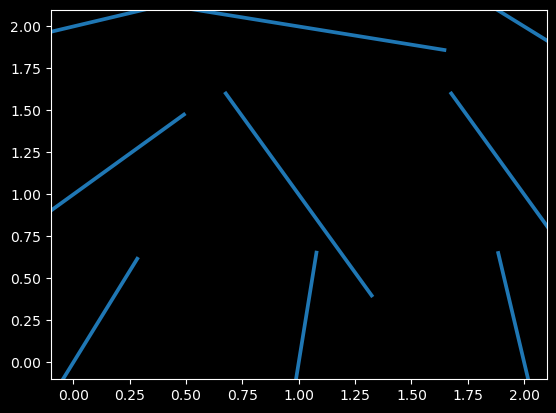

1
Prediction: +1/2 Defect
Prediction: +1/2 Defect 1 loc: 80 37
1
(100, 100)


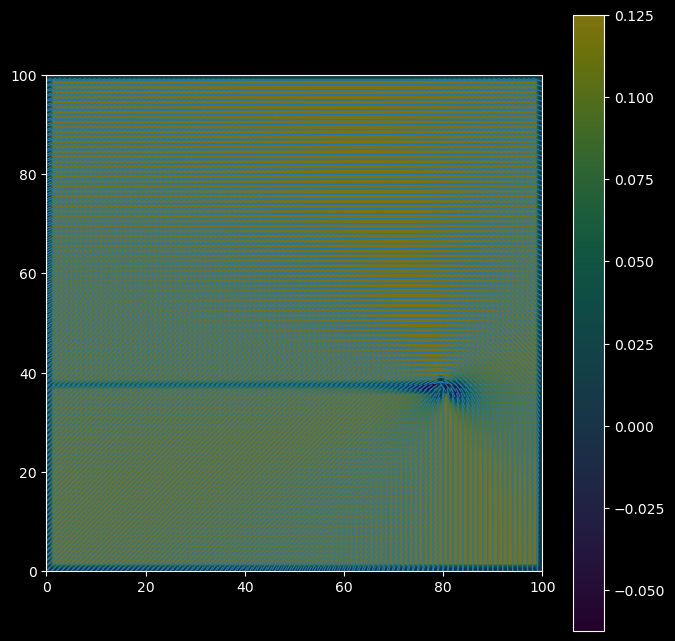

(100, 100)


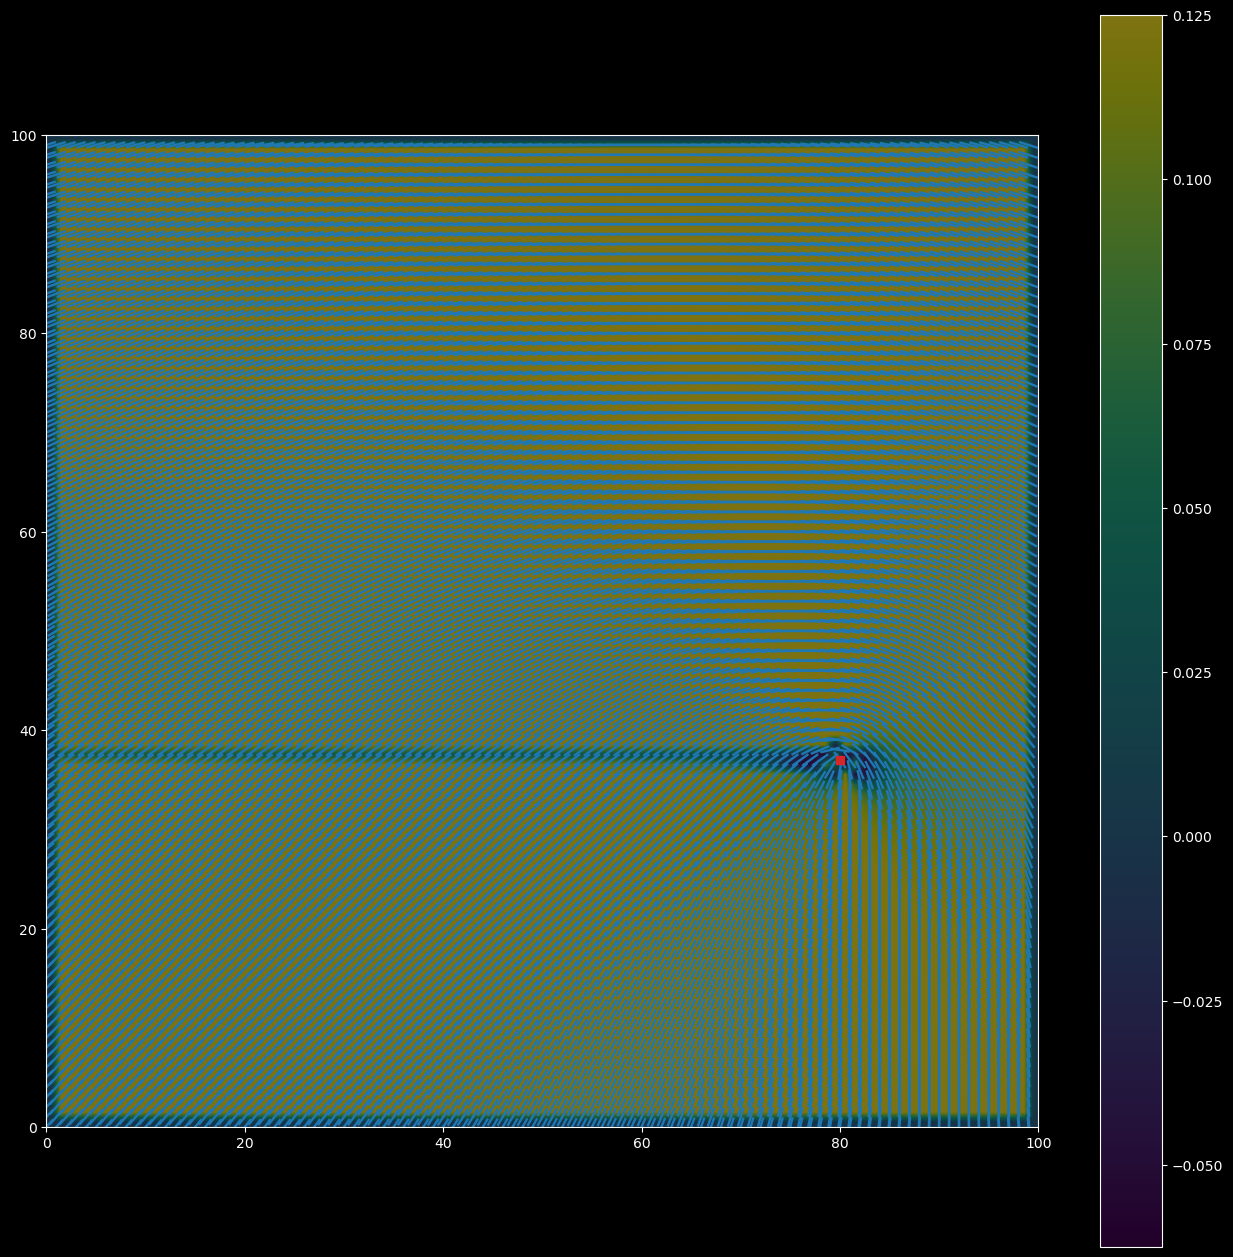

In [52]:
# this tests the moving window over a size of 100,100 for defect identification
defect_type = "+1/2"#np.random.choice(["+1/2","-1/2"])
defect_location = (np.random.randint(2,98),np.random.randint(2,98))
large_test_field = generate_defect_field(size=100,
                                         defect_type=defect_type,
                                         defect_location=defect_location)
print(defect_type)
print(defect_location)

def plot_defect_field(field,size,loc):
    x, y = np.meshgrid(np.arange(size), np.arange(size))
    plt.quiver(x,y,field[:, :, 0], field[:, :, 1],
                   pivot='mid',
                   headlength=0,
                   headwidth=0,
                   headaxislength=0,
                   color="tab:blue",
                   scale_units='xy',
                   scale=0.75
    )
    # plt.quiver(x,y,field[loc[0]-1:loc[0]+2, loc[1]-1:loc[1]+2, 0], 
    #                field[loc[0]-1:loc[0]+2, loc[1]-1:loc[1]+2, 1],
    #                pivot='mid',
    #                headlength=0.2,
    #                headwidth=0.2,
    #                headaxislength=0.1,
    #                color="tab:blue",
    #                scale_units='xy',
    #                scale=0.75
    # )
    # plt.plot(loc[0],loc[1],color="tab:red",marker='o')
    plt.show()

loc = defect_location
xmin = loc[0]-1
xmax = loc[0]+2
ymin = loc[1]-1
ymax = loc[1]+2
defect_highlighted_x = np.lib.stride_tricks.sliding_window_view(large_test_field[:,:,0],(3,3))
defect_highlighted_y = np.lib.stride_tricks.sliding_window_view(large_test_field[:,:,1],(3,3))
print(defect_highlighted_x.shape)

test_x = loc[1]-1
test_y = loc[0]-1
print(defect_highlighted_x[test_x,test_y].shape)

#plot_defect_field(defect_highlighted,3,defect_location)
defect_test_field = np.zeros((3,3,2))
defect_test_field[:,:,0] = defect_highlighted_x[test_x,test_y]
defect_test_field[:,:,1] = defect_highlighted_y[test_x,test_y]
plot_defect_field(defect_test_field,3,loc)
test_tensor = torch.tensor(defect_test_field.flatten(), dtype=torch.float32).unsqueeze(0)
# Make a prediction
with torch.no_grad():
    model.eval()
    output = model(test_tensor)
    prediction = torch.argmax(output,dim=1)

defect_types = ["No Defect", "+1/2 Defect", "-1/2 Defect"]
label = defect_types[prediction.item()]
print(prediction.item())
print("Prediction:", label)



defects_found = 0
defect_locations = []
for i in range(defect_highlighted_x.shape[0]):
    for j in range(defect_highlighted_y.shape[1]):
        defect_highlighted_field = np.zeros((3,3,2))
        defect_highlighted_field[:,:,0] = defect_highlighted_x[i,j]
        defect_highlighted_field[:,:,1] = defect_highlighted_y[i,j]
        test_tensor = torch.tensor(defect_highlighted_field.flatten(), dtype=torch.float32).unsqueeze(0)

        # Make a prediction
        with torch.no_grad():
            model.eval()
            output = model(test_tensor)
            prediction = torch.argmax(output,dim=1)
        defect_types = ["No Defect", "+1/2 Defect", "-1/2 Defect"]
        label = defect_types[prediction.item()]
        if prediction.item() > 0:
            print("Prediction:", label,prediction.item(),"loc:",j+1,i+1)
            defect_locations.append([j+1,i+1])
            defects_found += 1
print(defects_found)

fig,ax = plt.subplots(1,1,figsize=(8,8))
x, y = np.meshgrid(np.arange(100), np.arange(100))
quiver = ax.quiver(x,y,
                   large_test_field[:,:,0], #x
                   large_test_field[:,:,1], #y
                   pivot='mid',
                   headlength=0,
                   headwidth=0,
                   headaxislength=0,
                   color="tab:blue",
                   scale_units='xy',
                   scale=0.5
)
print(order_parameter_original.shape)
order_parameter_original = calculate_order_parameter(large_test_field)
pcm = ax.imshow(order_parameter_original,cmap="viridis",interpolation="bilinear",alpha=0.5,origin="lower",extent=(0,100,0,100))
fig.colorbar(pcm, ax=ax)
#defect_locations = np.array(defect_locations)
#ax.plot(defect_locations[:,0],defect_locations[:,1],color="tab:red",marker=",")
ax.axis("scaled")
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
plt.show()

fig,ax = plt.subplots(1,1,figsize=(16,16))
x, y = np.meshgrid(np.arange(100), np.arange(100))
quiver = ax.quiver(x,y,
                   large_test_field[:,:,0], #x
                   large_test_field[:,:,1], #y
                   pivot='mid',
                   headlength=0,
                   headwidth=0,
                   headaxislength=0,
                   color="tab:blue",
                   scale_units='xy',
                   scale=0.5
)
print(order_parameter_original.shape)
order_parameter_original = calculate_order_parameter(large_test_field)
pcm = ax.imshow(order_parameter_original,cmap="viridis",interpolation="bilinear",alpha=0.5,origin="lower",extent=(0,100,0,100))
fig.colorbar(pcm, ax=ax)
defect_locations = np.array(defect_locations)
ax.scatter(defect_locations[:,0],defect_locations[:,1],color="tab:red",marker=",")
ax.axis("scaled")
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
plt.show()

[-0.5 -0.5]
[(78, 53), (81, 3)]


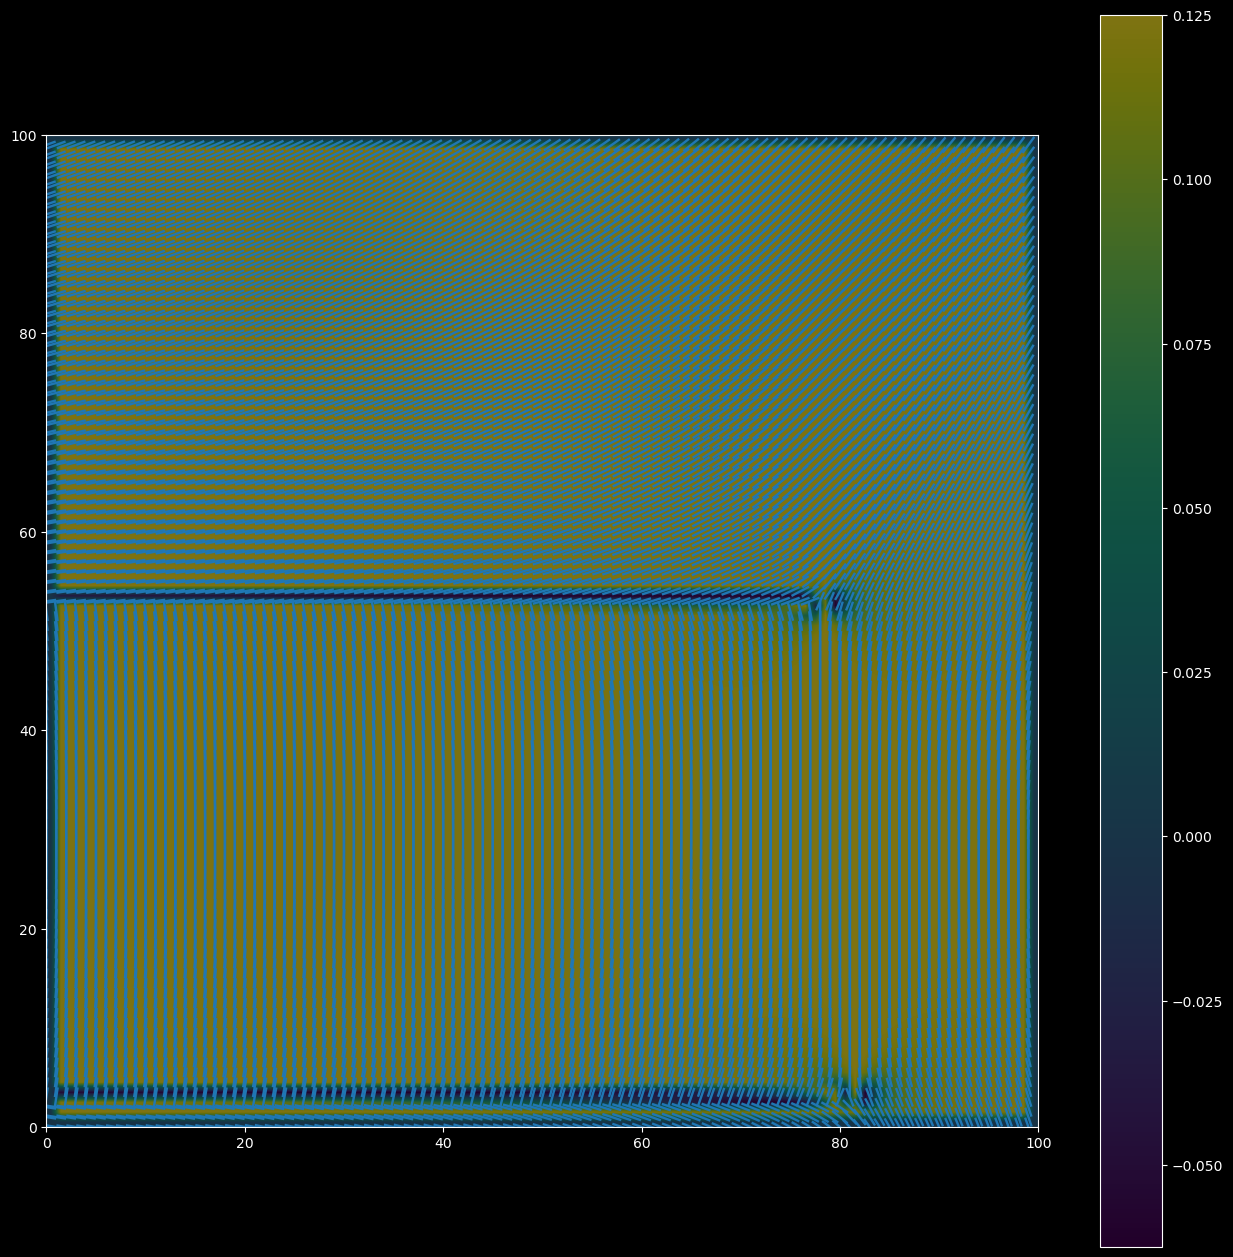

In [45]:
def gen_multiple_defects(size=100,
                         defect_charges=[0.5],
                         defect_locations=[(1,1)]):
    x,y = np.meshgrid(np.arange(size),np.arange(size))
    field = np.zeros((size,size,2))
    for charge,defect_location in zip(defect_charges,defect_locations):
        rotation = np.random.uniform(0,np.pi*2)
        r = np.sqrt((x-defect_location[0])**2 + (y-defect_location[1])**2)
        theta = charge * np.arctan2(y-defect_location[1],x-defect_location[0])
        field[:,:,0] += np.sin(theta)
        field[:,:,1] += -np.cos(theta)

    norm = np.sqrt(field[:,:,0]**2 + field[:,:,1]**2)
    field[:,:,0] = field[:,:,0]/norm
    field[:,:,1] = field[:,:,1]/norm
    return field
        

num_defects = 2
fig,ax = plt.subplots(1,1,figsize=(16,16))
x, y = np.meshgrid(np.arange(100), np.arange(100))
defect_charges = np.random.choice([0.5,-0.5],num_defects)
defect_locations = [(np.random.randint(2,98),np.random.randint(2,98)) for _ in range(num_defects)]
print(defect_charges)
print(defect_locations)
field = gen_multiple_defects(100,defect_charges,defect_locations)
quiver = ax.quiver(x,y,
                   field[:,:,0], #x
                   field[:,:,1], #y
                   pivot='mid',
                   headlength=0,
                   headwidth=0,
                   headaxislength=0,
                   color="tab:blue",
                   scale_units='xy',
                   scale=0.5
)
order_parameter = calculate_order_parameter(field)
pcm = ax.imshow(order_parameter,cmap="viridis",interpolation="bilinear",alpha=0.5,origin="lower",extent=(0,100,0,100))
fig.colorbar(pcm, ax=ax)
ax.axis("scaled")
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
plt.show()

Prediction: -1/2 Defect 2 loc: 1 3
Prediction: -1/2 Defect 2 loc: 2 3
Prediction: -1/2 Defect 2 loc: 3 3
Prediction: -1/2 Defect 2 loc: 4 3
Prediction: -1/2 Defect 2 loc: 5 3
Prediction: -1/2 Defect 2 loc: 6 3
Prediction: -1/2 Defect 2 loc: 7 3
Prediction: -1/2 Defect 2 loc: 8 3
Prediction: -1/2 Defect 2 loc: 9 3
Prediction: -1/2 Defect 2 loc: 10 3
Prediction: -1/2 Defect 2 loc: 11 3
Prediction: -1/2 Defect 2 loc: 12 3
Prediction: -1/2 Defect 2 loc: 13 3
Prediction: -1/2 Defect 2 loc: 14 3
Prediction: -1/2 Defect 2 loc: 15 3
Prediction: -1/2 Defect 2 loc: 16 3
Prediction: -1/2 Defect 2 loc: 17 3
Prediction: -1/2 Defect 2 loc: 18 3
Prediction: -1/2 Defect 2 loc: 19 3
Prediction: -1/2 Defect 2 loc: 20 3
Prediction: -1/2 Defect 2 loc: 21 3
Prediction: -1/2 Defect 2 loc: 22 3
Prediction: -1/2 Defect 2 loc: 23 3
Prediction: -1/2 Defect 2 loc: 24 3
Prediction: -1/2 Defect 2 loc: 25 3
Prediction: -1/2 Defect 2 loc: 26 3
Prediction: -1/2 Defect 2 loc: 27 3
Prediction: -1/2 Defect 2 loc: 28 3
P

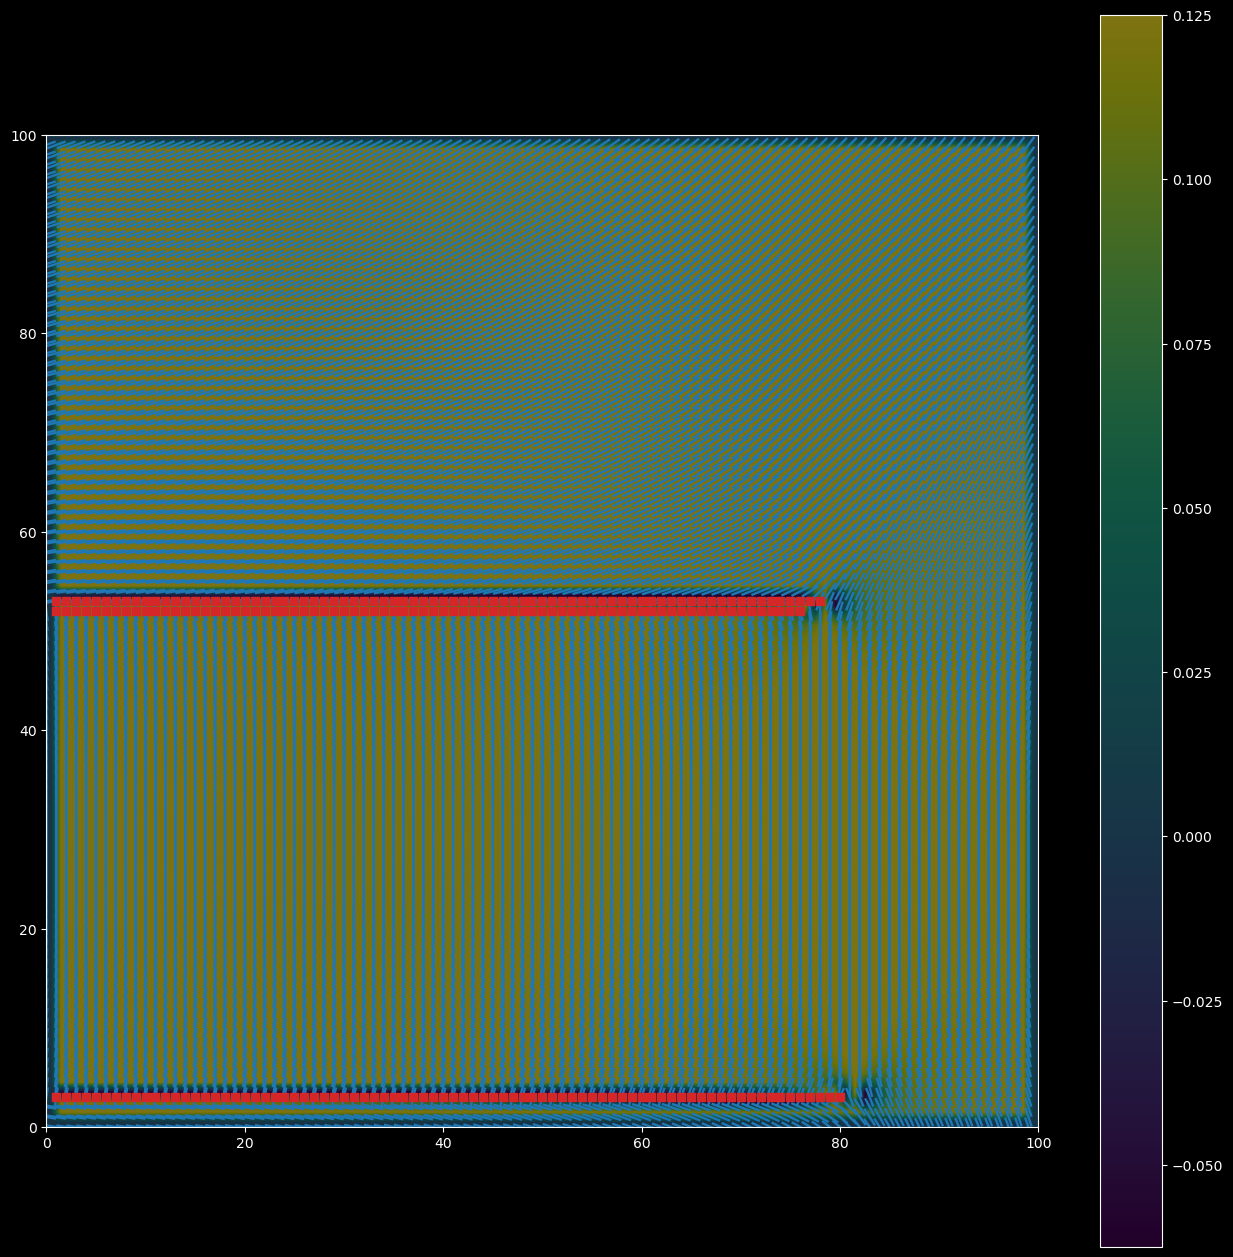

In [46]:
defect_highlighted_x = np.lib.stride_tricks.sliding_window_view(field[:,:,0],(3,3))
defect_highlighted_y = np.lib.stride_tricks.sliding_window_view(field[:,:,1],(3,3))
defects_found = 0
defect_locations = []
for i in range(defect_highlighted_x.shape[0]):
    for j in range(defect_highlighted_y.shape[1]):
        defect_highlighted_field = np.zeros((3,3,2))
        defect_highlighted_field[:,:,0] = defect_highlighted_x[i,j]
        defect_highlighted_field[:,:,1] = defect_highlighted_y[i,j]
        test_tensor = torch.tensor(defect_highlighted_field.flatten(), dtype=torch.float32).unsqueeze(0)

        # Make a prediction
        with torch.no_grad():
            model.eval()
            output = model(test_tensor)
            prediction = torch.argmax(output,dim=1)
        defect_types = ["No Defect", "+1/2 Defect", "-1/2 Defect"]
        label = defect_types[prediction.item()]
        if prediction.item() > 0:
            print("Prediction:", label,prediction.item(),"loc:",j+1,i+1)
            defect_locations.append([j+1,i+1])
            defects_found += 1
print(defects_found)

fig,ax = plt.subplots(1,1,figsize=(16,16))
x, y = np.meshgrid(np.arange(100), np.arange(100))
quiver = ax.quiver(x,y,
                   field[:,:,0], #x
                   field[:,:,1], #y
                   pivot='mid',
                   headlength=0,
                   headwidth=0,
                   headaxislength=0,
                   color="tab:blue",
                   scale_units='xy',
                   scale=0.5
)
order_parameter = calculate_order_parameter(field)
pcm = ax.imshow(order_parameter,cmap="viridis",interpolation="bilinear",alpha=0.5,origin="lower",extent=(0,100,0,100))
fig.colorbar(pcm, ax=ax)
defect_locations = np.array(defect_locations)
ax.scatter(defect_locations[:,0],defect_locations[:,1],color="tab:red",marker=",")
ax.axis("scaled")
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
plt.show()

In [55]:
from matplotlib import cm
from numba import jit
class Qsim:
    def __init__(self,nsteps,L):
        # number of grad spacings in x,y
        self.Lx = L
        self.Ly = L

        # phase free energy density constants and elastic constant (single constant approximation)
        self.A = -1
        self.C = 1.5
        self.S0 = np.sqrt(-self.A/(2*self.C))
        self.L = 1

        # gradient descent minimizer
        self.Gamma = 0.2

        # stopping condition
        self.Hsize_stop = 0.1#10e-5

        self.printstep = nsteps
        self.plotstep = nsteps
        # declare an Lx x Ly x 2 array, to store (Qxx,Qxy) at each site
        # initialize Q with random values between -S0 and S0
        self.Q = self.S0*2*(np.random.rand(self.Lx,self.Ly,2)-0.5)

    def set_initial_condition(self):
	    #set the initial condition to be the top
        pass

    #@jit(nopython=True)
    def trQsq(self,Qxx,Qxy):
        return(2*(Qxx*Qxx+Qxy*Qxy))    

    def trace_Q_squared(self,Qxx,Qxy):
        return(2*(Qxx*Qxx+Qxy*Qxy))  

    def get_director(self):
        S = np.zeros((self.Lx,self.Ly))
        nx = np.zeros((self.Lx,self.Ly))
        ny = np.zeros((self.Lx,self.Ly))
        for x in np.arange(0,self.Lx):
            for y in np.arange(0,self.Ly):
                S[x,y] = 0.5*np.sqrt(self.trace_Q_squared(self.Q[x,y,0],self.Q[x,y,1]))
                a = self.Q[x,y,0]
                b = self.Q[x,y,1]
                eigenvalues,eigenvectors = np.linalg.eig(np.array([[a,b],[b,-a]]))
                nx[x,y] = eigenvectors[0,np.argmax(eigenvalues)]
                ny[x,y] = eigenvectors[1,np.argmax(eigenvalues)]
        return S,nx,ny

    def update_plot(self,b_made_colorbar):
        # plot of director field and order updates every printstep timesteps
        S,nx,ny = self.get_director()
        norm = cm.colors.Normalize(vmax=1,vmin=0)
        plt.pcolormesh(S/self.S0,norm=norm)
        if not b_made_colorbar:
            plt.colorbar(label="S/S0")
        plt.quiver(nx,ny,headwidth=0,units='x',scale=1,pivot='mid')
        plt.ion()
        plt.draw()
        plt.pause(0.001)

    def update_plot_with_defects(self,b_made_colorbar,defect_locs):
        # plot of director field and order updates every printstep timesteps
        S,nx,ny = self.get_director()
        norm = cm.colors.Normalize(vmax=1,vmin=0)
        plt.pcolormesh(S/self.S0,norm=norm)
        if not b_made_colorbar:
            plt.colorbar(label="S/S0")
        plt.quiver(nx,ny,headwidth=0,units='x',scale=1,pivot='mid')
        defect_locations = np.array(defect_locs)
        plt.scatter(defect_locations[:,0],defect_locations[:,1],color="tab:red",marker=",")
        plt.ion()
        plt.draw()
        plt.pause(0.001)
        
    #@jit(nopython=True)
    def calc_Q(self,F,H,Hsize):
        for x in np.arange(0,self.Lx):
            for y in np.arange(0,self.Ly):
                trQ2 = self.trQsq(self.Q[x,y,0],self.Q[x,y,1])
                f_bulk = 0.5*self.A*trQ2 + 0.25*self.C*trQ2*trQ2
                xp1 = (x+1)%self.Lx
                xm1 = (x-1)%self.Lx
                yp1 = (y+1)%self.Ly
                ym1 = (y-1)%self.Ly
                dxQ = 0.5*(self.Q[xp1,y]-self.Q[xm1,y])
                dx2Q = self.Q[xp1,y] - 2*self.Q[x,y]+ self.Q[xm1,y]
                dyQ = 0.5*(self.Q[x,yp1]-self.Q[x,ym1])
                dy2Q = self.Q[x,yp1] - 2*self.Q[x,y]+ self.Q[x,ym1]
                f_distortion = self.L*(dxQ[0]*dxQ[0] + dxQ[1]*dxQ[1] + dyQ[0]*dyQ[0] + dyQ[1]*dyQ[1])
                F = F + f_bulk + f_distortion
                Laplacian_Q = dx2Q + dy2Q
                H[x,y] = self.L*Laplacian_Q - self.Q[x,y]*(self.A+0.5*self.C*trQ2)
                Hsize = Hsize + (H[x,y,0]*H[x,y,0] + H[x,y,1]*H[x,y,1])
        return F,H,Hsize

    def find_defects_using_model(self,model):
        _,nx,ny = self.get_director()
        defect_highlighted_x = np.lib.stride_tricks.sliding_window_view(nx,(3,3))
        defect_highlighted_y = np.lib.stride_tricks.sliding_window_view(ny,(3,3))
        defects_found = 0
        defect_locations = []
        for i in range(defect_highlighted_x.shape[0]):
            for j in range(defect_highlighted_y.shape[1]):
                defect_highlighted_field = np.zeros((3,3,2))
                defect_highlighted_field[:,:,0] = defect_highlighted_x[i,j]
                defect_highlighted_field[:,:,1] = defect_highlighted_y[i,j]
                test_tensor = torch.tensor(defect_highlighted_field.flatten(), dtype=torch.float32).unsqueeze(0)

                # Make a prediction
                with torch.no_grad():
                    model.eval()
                    output = model(test_tensor)
                    prediction = torch.argmax(output,dim=1)
                defect_types = ["No Defect", "+1/2 Defect", "-1/2 Defect"]
                label = defect_types[prediction.item()]
                if prediction.item() > 0:
                    #print("Prediction:", label,prediction.item(),"loc:",j+1,i+1)
                    defect_locations.append([j+1,i+1])
                    defects_found += 1
        print("Defects Found:",defects_found)
        return defect_locations

    def run_simulation(self,model=None):
        if model == None:
            print("No defect finding")
        else:
            print("Defect finding turned on")
        
        b_stop_search = False
        b_made_colorbar = False
        stepnum = 0

        print("stepnum\t Hsize\t F")

        # loop for relaxation steps
        self.update_plot(b_made_colorbar)
        b_made_colorbar = True
        while not b_stop_search:
            H = np.zeros((self.Lx,self.Ly,2))
            F = 0
            Hsize = 0
            F,H,Hsize = self.calc_Q(F,H,Hsize)

            Hsize = np.sqrt(Hsize)
            #update
            self.Q = self.Q + self.Gamma*H
            stepnum = stepnum+1

            #stopping condition
            if (Hsize <= self.Hsize_stop):
                b_stop_search = True
                print(f'Success: reached stopping condition Hsize = {Hsize} <= {self.Hsize_stop}')

            # monitor progress
            if (stepnum%self.printstep) == 0:
                print(f'{stepnum}\t {Hsize}\t {F}')
            if (stepnum%self.plotstep) == 0:
                if model != None:
                    defect_locs = self.find_defects_using_model(model)
                    self.update_plot_with_defects(b_made_colorbar,defect_locs)
                else:
                    self.update_plot(b_made_colorbar)
                b_made_colorbar = True
        print(f'Done')

Defect finding turned on
stepnum	 Hsize	 F


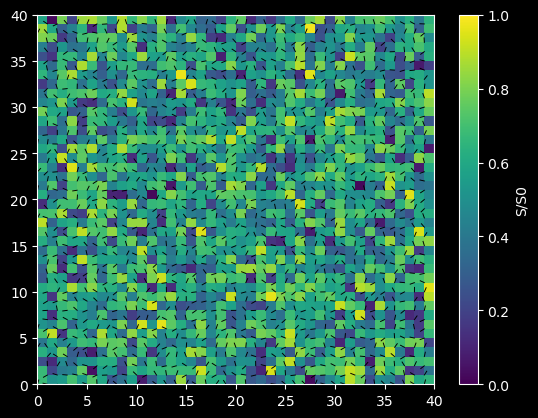

100	 0.9179663836745793	 -2.4116618459644816
Defects Found: 2


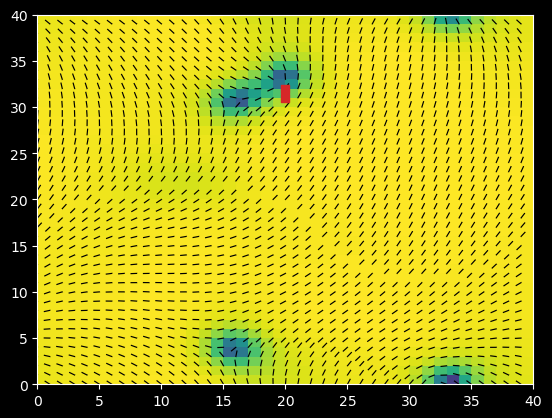

200	 0.287581400604298	 -0.7955420419269916
Defects Found: 0


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

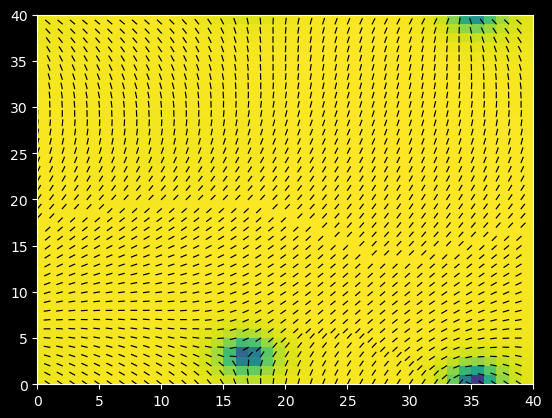

In [56]:
sim = Qsim(100,40)
sim.run_simulation(model)